## Predictive Modeling - Problem Definition
Our goal is to build a binary classification model to predict whether a delivery will be late, based solely on information available at the time of purchase.

Target variable: `is_late`  
Type: Binary Classification (0 = On time, 1 = Late)


### Data Loading


In [111]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.parquet import to_parquet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [112]:
# Import dataframe
current_dir = os.getcwd()
data_path = os.path.abspath(os.path.join(current_dir, "..", "data", "processed"))
df_modeling = pd.read_parquet(os.path.join(data_path, "df_modeling.parquet"))



### Feature Engineering P2

#### Product Volume

In [113]:
# Product Volume
df_modeling['product_volume'] = df_modeling['product_length_cm'] * df_modeling['product_height_cm'] * df_modeling['product_width_cm']

#### Euclidian distance between customer and seller

In [114]:
# Distance between customer and seller

# Reading geolocation csv
current_dir = os.getcwd()
data_path = os.path.abspath(os.path.join(current_dir, '..', 'data', 'processed'))
geolocation = pd.read_csv(os.path.join(data_path, 'geolocation.csv'))

In [115]:
# Group by zip code prefix and calculate the overall mean of the coordinates
geo_mean = geolocation.groupby('geolocation_zip_code_prefix', as_index = False).agg({
    'geolocation_lat':'mean',
    'geolocation_lng':'mean'
})

In [116]:
# Rename from geolocation lat and long to customer lat and long
customers_geo = geo_mean.rename(columns={
    'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

In [117]:
# Rename from geolocation lat and long to seller lat and long
seller_geo = geo_mean.rename(columns={
    'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

In [118]:
# Merge the datagrame customer_geo and seller_geo with df_modeling
df_modeling = df_modeling.merge(customers_geo, on='customer_zip_code_prefix', how='left')
df_modeling = df_modeling.merge(seller_geo, on='seller_zip_code_prefix', how='left')

In [119]:
# Euclidian distance between customer and seller
df_modeling['distance_seller_customer'] = np.sqrt(
    (df_modeling['customer_lat'] - df_modeling['customer_lng'])**2 +
    (df_modeling['customer_lat'] - df_modeling['customer_lng'])**2
)

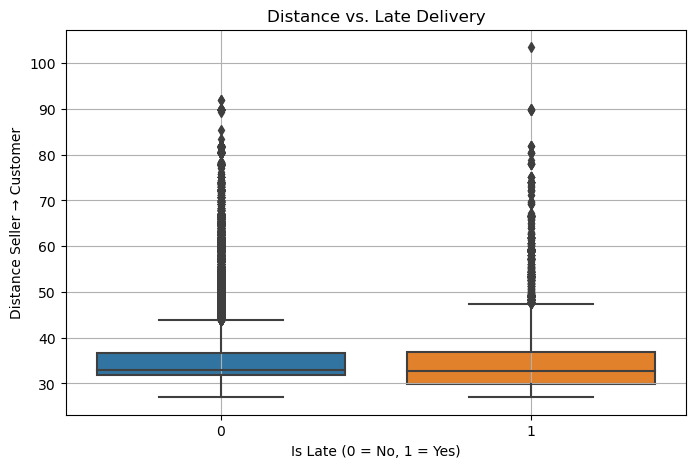

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='is_late', y='distance_seller_customer', data=df_modeling)
plt.title('Distance vs. Late Delivery')
plt.xlabel('Is Late (0 = No, 1 = Yes)')
plt.ylabel('Distance Seller → Customer')
plt.grid(True)
plt.show()


### Processing time (days)

In [121]:
df_modeling['processing_time'] = (df_modeling['order_delivered_carrier_date'] - df_modeling['order_approved_at']).dt.days


### Estimated time delivery (days)

In [122]:
df_modeling['estimated_time'] = (df_modeling['order_estimated_delivery_date'] - df_modeling['order_approved_at']).dt.days

In [123]:
df_modeling.columns.unique

<bound method Index.unique of Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_month', 'is_late', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'customer_region', 'seller_region', 'product_volume',
       'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng',
       'distance_seller_customer', 'processi

### Model First Try

In [124]:
# selecting numeric features
selected_features = df_modeling[['product_volume',
                                 'product_weight_g',
                                 'distance_seller_customer',
                                 'freight_value',
                                 'payment_value',
                                 'price',
                                 'processing_time',
                                 'estimated_time'
]]
    

In [125]:
# checking null values
selected_features.isnull().sum()

product_volume                 0
product_weight_g               0
distance_seller_customer     311
freight_value                  0
payment_value                  0
price                          0
processing_time             1246
estimated_time                15
dtype: int64

In [126]:
total_rows = len(df_modeling)
unknown_count = selected_features.isnull().any(axis=1).sum()
percentage_unknown = (unknown_count / total_rows) * 100

print(f"'unknown' represents {percentage_unknown:.2f}% of the dataset.")

'unknown' represents 1.33% of the dataset.


In [127]:
selected_features = selected_features.fillna(0)
selected_features.isnull().sum()

product_volume              0
product_weight_g            0
distance_seller_customer    0
freight_value               0
payment_value               0
price                       0
processing_time             0
estimated_time              0
dtype: int64

In [128]:
# Train and test
X = selected_features
y = df_modeling['is_late']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [129]:
# Training a model using random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

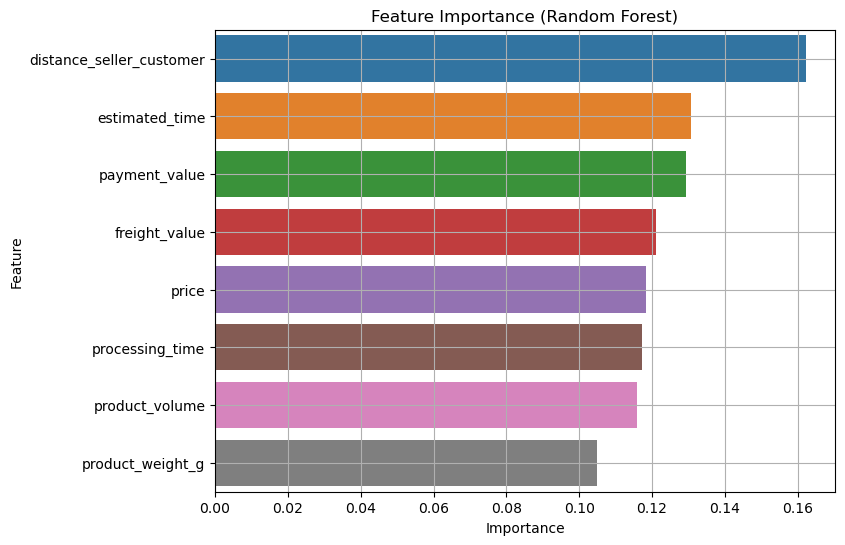

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.DataFrame({
    'feature': selected_features.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()


In [131]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[21492    63]
 [ 1321   460]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21555
           1       0.88      0.26      0.40      1781

    accuracy                           0.94     23336
   macro avg       0.91      0.63      0.68     23336
weighted avg       0.94      0.94      0.93     23336



In [132]:
df_modeling.columns.unique

<bound method Index.unique of Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_month', 'is_late', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'customer_region', 'seller_region', 'product_volume',
       'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng',
       'distance_seller_customer', 'processi

### Model second try

In [133]:
# create df with categorical features
df_modeling['order_purchase_month'] = df_modeling['order_purchase_month'].astype(str)
categorical_features = df_modeling[[
    'order_purchase_month',
    'customer_state',
    'seller_state',
    'product_category_name'
]]

In [134]:
# Transform categorical features in bynaries
df_encoded = pd.get_dummies(categorical_features, drop_first=True)

In [135]:
# Concat numeric columns with categorical columns
X = pd.concat([selected_features, df_encoded], axis=1)
y = df_modeling['is_late']

In [136]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# Avaliação
y_probs = model.predict_proba(X_test)
limiar = 0.32
y_pred_adjusted = (y_probs[:, 1] >= limiar).astype(int)

print(classification_report(y_test, y_pred_adjusted))
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21555
           1       0.50      0.49      0.49      1781

    accuracy                           0.92     23336
   macro avg       0.73      0.72      0.73     23336
weighted avg       0.92      0.92      0.92     23336

[[20685   870]
 [  910   871]]


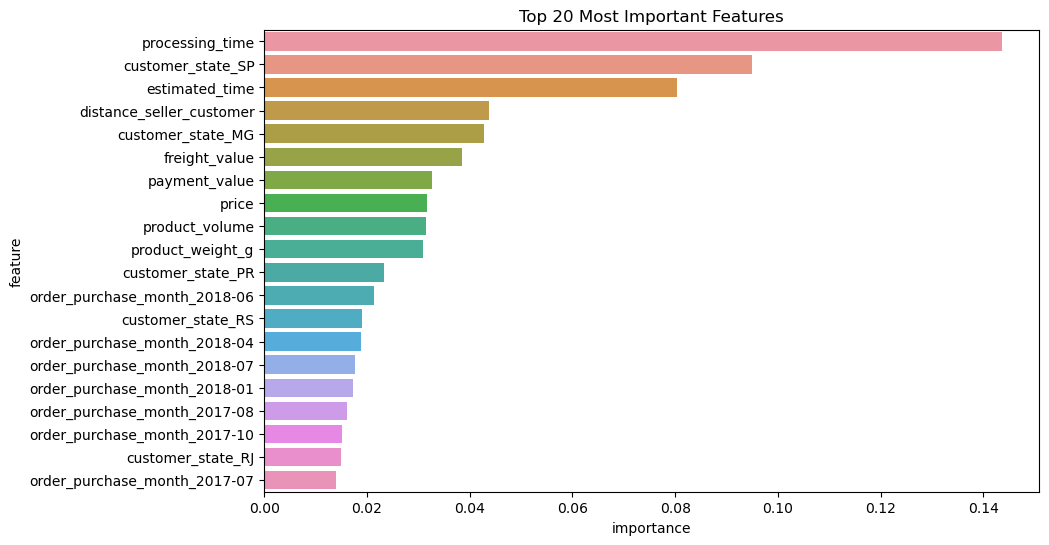

In [137]:
importances = model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualizar top 20
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.show()